<a href="https://colab.research.google.com/github/TerryTian21/PyTorch-Practice/blob/main/Tutorials/Intro_to_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GANs)

## Theory

GANs learn to generate new data with teh same statistics as the training set. They consist of 2 networks playing an adversarial game against each other.
- Generator : produces fake dta and tries to trick discriminator
- Discriminator : INspects the fake data and determines if it is real or fake

Generator and Discriminator are randomly initialized in the beginning and are trained simultaneou

## Coding

In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.2 MB/s eta 0:00:00


In [2]:
import os
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

random_seed =42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

## Model Setup

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="data",
                 batch_size=BATCH_SIZE,
                 num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # The normalization is done with the calculated mean and sd of the training set
        self.transform = v2.Compose([v2.ToTensor(),
                                     v2.Normalize((0.1207,), (0.3081,))])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [4]:
# Create Discriminator Class with output [0,1]

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    #Simple CNN
    self.layer_stack_1 = nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
    )

    self.layer_stack_2 = nn.Sequential(
        nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=0),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
    )

    self.fc1 = nn.Linear(320, 50)
    self.classifier = nn.Linear(50,1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer_stack_1(x)
    x = self.layer_stack_2(x)

    x = x.view(-1, 320)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.classifier(x)
    return torch.sigmoid(x)

In [5]:
# Test the model on a random input

tensor = torch.randn(28, 28).unsqueeze(0)
test_discriminator = Discriminator()

out = test_discriminator(tensor)
out

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


tensor([[0.4930]], grad_fn=<SigmoidBackward0>)

What is `nn.ConvTranspose2d()`

Key Parameters:
- in_channels
- out_channels
- kernel_size
- stride = 1
- padding = 0

Applies a 2d transposed convolution over an input image of serveral input planes. Can be understood as a de-convolution but doesn't compute an acutal inverse of the convolutions.
- Image take a smaller input and expanding to produce a larger output
- Used to upsample feature maps
- Pads input with zeros and sliding the filter over the input and performs convolution like operations which expand the dimension of the input

https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides_transposed.gif

<br>

Suppose you have 10 feature maps and wanted to output 3 feature maps. Then you apply 3 different weigth matrices (kernels) that produce the 3 feature maps.

This is separate from the spatial dimensions of each feature map, which is determined by the convolution parameters (stride, padding, kernel size). Note the two kernels are not the same.

In [6]:
# Crate the Generator Class like real data [1, 28, 28]

class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.lin1 = nn.Linear(latent_dim, 7*7*64) # [n, 256, 7, 7]
    self.ct1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2)
    self.ct2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2)
    self.conv = nn.Conv2d(16, 1, kernel_size=7)
    self.relu = nn.ReLU()

  def forward(self, x):

    # Pass latent space input into linear layer and reshape
    x = self.lin1(x)
    x = self.relu(x)
    x = x.view(-1, 64, 7, 7)

    # Upsample (transposed conv) 16x16 images with (64 feature maps)
    x = self.ct1(x)
    x = self.relu(x)

    # Upsample to 34x34 (16 feature maps)
    x = self.ct2(x)
    x = self.relu(x)

    # Apply convovlution to reduce dimension to 28x28
    return self.conv(x)



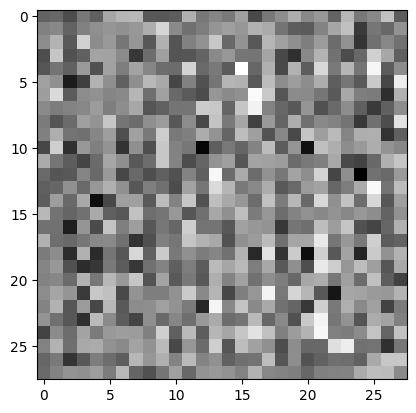

In [7]:
t = torch.randn(100)
test_generator = Generator(latent_dim=100)
out = test_generator(t)
plt.imshow(out.detach().numpy().squeeze(), cmap="gray")

## Training

Note : Consider removing the sigmoid function from the discriminator and use `BCEWithLogits()` for numeric stability
- How errors introduced in the algorithm affect the result
- For example if there is a slight deviation $\hat{x}$ from $x$ does the output $\frac{f(\hat{x}) - f(x)}{f(x)} < O_{mach}$ where $O_{mach}$ is the machine precision.
- Does nearly right problem give nearly right solution

This is because by combining the sigmoid and loss function into a single layer, we can take advantage of the *log-sum-exp* trick

Some important notes about the following class:

* `self.detach()` - Used to create a new tensor separate from the compuation graph without the need for gradients

* `pytorch lightning` - Is a libarary that provides a higher level API for pytorch code. No need to call `loss.backward()` for `optimizer.step()` when training the model

* Generator + Discriminator : The two classes defined above are instantiated and trained simultaneously.

* Train Step
  * The generator is trained by producing a set of fake imagnes and using the discriminator to verify using the BCE Loss. Generator is the updated using the results from the loss
  * The discriminator is trained by averaging the loss from using fake vs real images and comparing the predictions to the true labels.


EDIT: Tryning the same training with weight initialization

In [21]:
# Initalize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [22]:
class GAN(pl.LightningModule):
  def __init__(self, latent_dim=100, lr=0.0002):
    super().__init__()

    self.automatic_optimization = False
    # Hyperparams
    self.save_hyperparameters()
    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.generator.apply(weights_init)
    self.discriminator = Discriminator()
    self.discriminator.apply(weights_init)
    self.loss = {"d_loss": [], "g_loss": []}

    # random noise
    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, x):
    return self.generator(x)

  def adversarial_loss(self, y_preds, y):
    loss = nn.BCELoss()
    return loss(y_preds, y)

  def training_step(self, batch, batch_indx):
    real_imgs, _ = batch
    g_opt, d_opt = self.optimizers()

    # Sample noise
    z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # Train the generator: Max log(D(G(x))) where x is fake images
    ##############################################################
    fake_imgs = self(z)
    y_preds = self.discriminator(fake_imgs)

    y = torch.ones(real_imgs.size(0), 1)
    y = y.type_as(real_imgs)

    g_loss = self.adversarial_loss(y_preds, y)

    # Manual optimization
    g_opt.zero_grad()
    self.manual_backward(g_loss)
    g_opt.step()

    self.loss["g_loss"].append(g_loss)

    # Train discriminator : Max log(D(x)) + log(1 - D(G(z)))
    ############################################################
    # How well can it label as real
    d_opt.zero_grad()
    y_preds_real = self.discriminator(real_imgs)

    y_real = torch.ones(real_imgs.size(0), 1) # Use torch dot ones because you expect them to all be real images and in binary classification the label is 1
    y_real = y_real.type_as(real_imgs)

    real_loss = self.adversarial_loss(y_preds_real, y_real)
    real_loss.backward()

    # How well can it label as fake
    y_preds_fake = self.discriminator(self(z).detach()) # Need the detach to prevent doing calculations twice -> detach from graph

    y_fake = torch.zeros(real_imgs.size(0), 1)
    y_fake = y_fake.type_as(real_imgs)

    fake_loss = self.adversarial_loss(y_preds_fake, y_fake)
    fake_loss.backward()

    d_loss = (real_loss + fake_loss) / 2

    # Manual optimization
    d_opt.step()

    self.loss['d_loss'].append(d_loss)

  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_generator = torch.optim.Adam(params=self.generator.parameters(),
                                     lr=lr)
    opt_discriminator = torch.optim.Adam(params=self.discriminator.parameters(),
                                         lr=lr)

    # Second empty list is for the scheduler
    return [opt_generator, opt_discriminator], []


  def plot_imgs(self):
    # Find the type of device the model uses and set tensor to that device
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu() # On cpu for plotting

    print(f'Epoch: {self.current_epoch}')
    fig = plt.figure()
    for i in range(sample_imgs.size(0)):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray_r", interpolation='none')
      plt.axis(False)
    plt.show()

  def on_train_epoch_end(self):
    self.plot_imgs()
  # What to do at the end of each epoch (plot generated images)



In [23]:
dm = MNISTDataModule()
model = GAN()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Epoch: 0


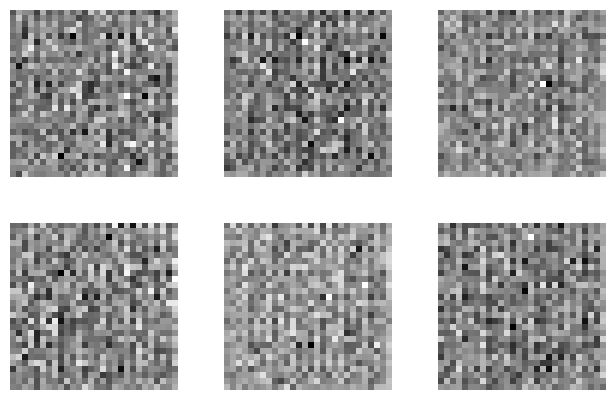

In [24]:
model.on_train_epoch_end()

## Fitting Model

No need to write the training loop; the traininer automates everything else.
- Automatically putting model in `train()` and `eval()` modes
- Running training validation and test dataloaders
- Calling callbacks

In [25]:
pl.__version__

'2.1.2'

In [26]:
ones = torch.ones(10, 1)

In [27]:
tensor = torch.rand(10, 1)
loss = nn.BCELoss()
out = loss(tensor, ones)
out

tensor(0.9060)

This is the result of 30 epochs of training. We see some semblance of handwritten digits.

**NOTE** : What changed - when training the discriminator make sure to call `loss.backward()` on both the fake and real loss before stepping the optimizer.
- This seemed to give improved performance

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
/usr/loc

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0


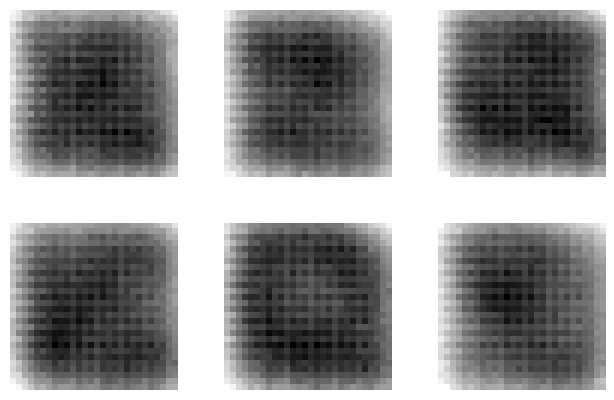

Epoch: 1


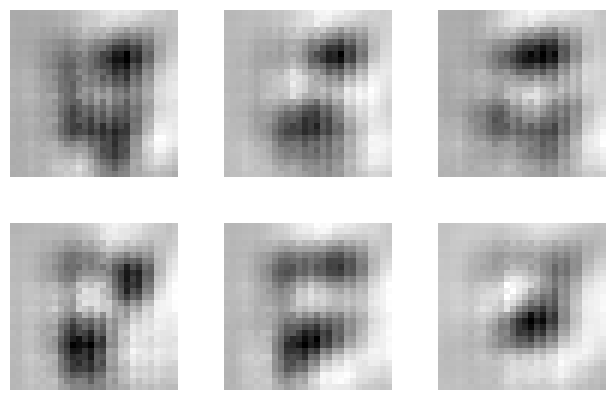

Epoch: 2


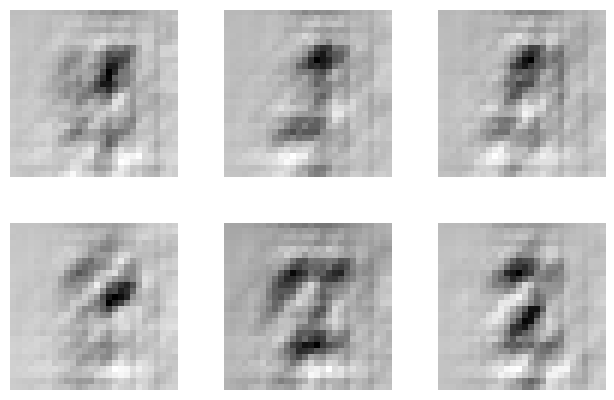

Epoch: 3


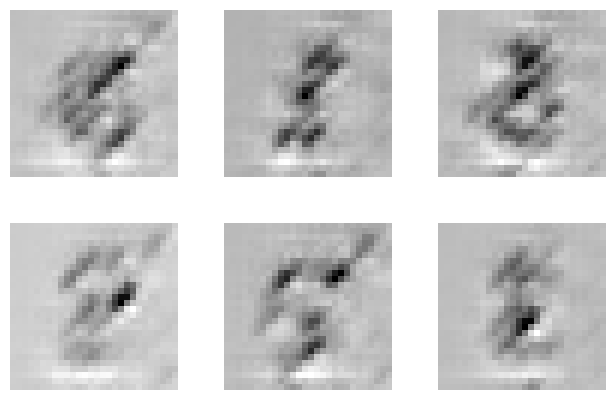

Epoch: 4


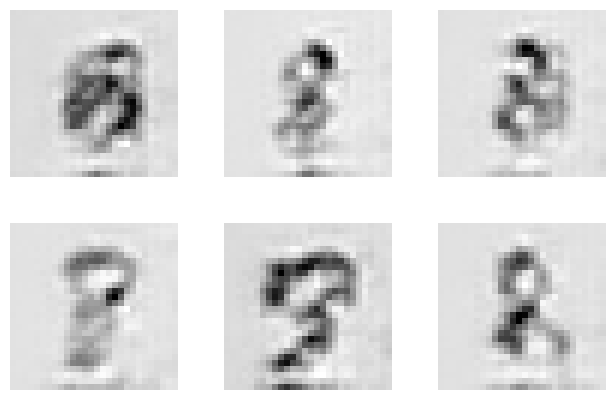

Epoch: 5


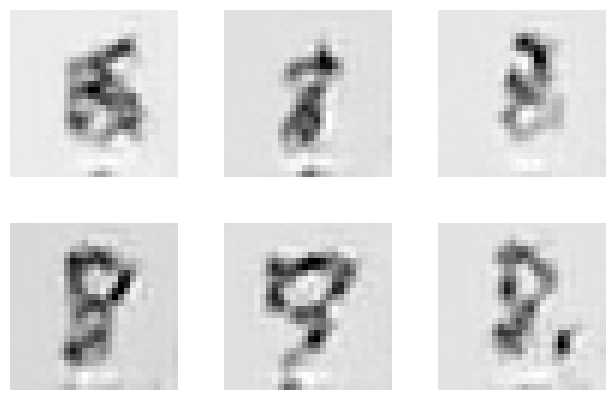

Epoch: 6


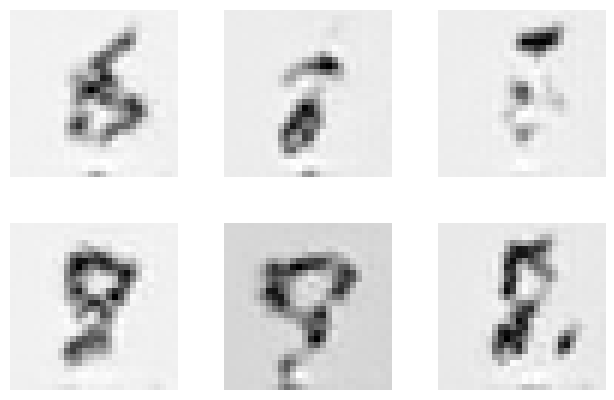

Epoch: 7


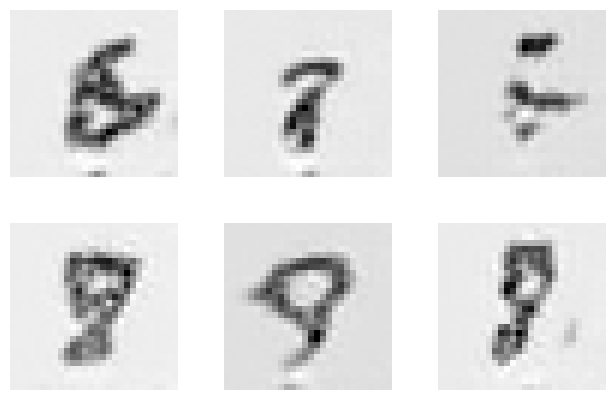

Epoch: 8


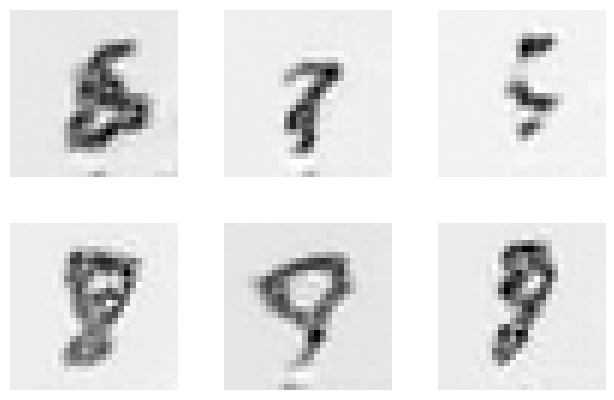

Epoch: 9


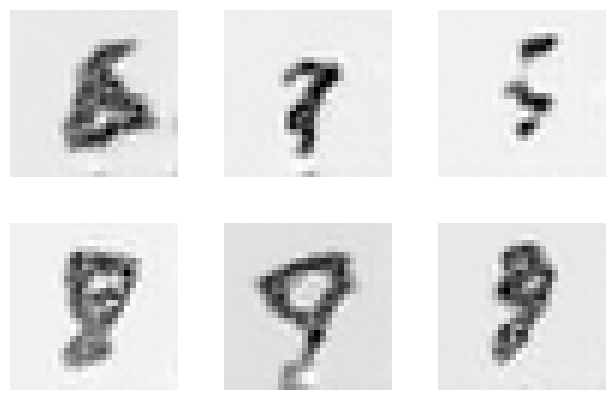

Epoch: 10


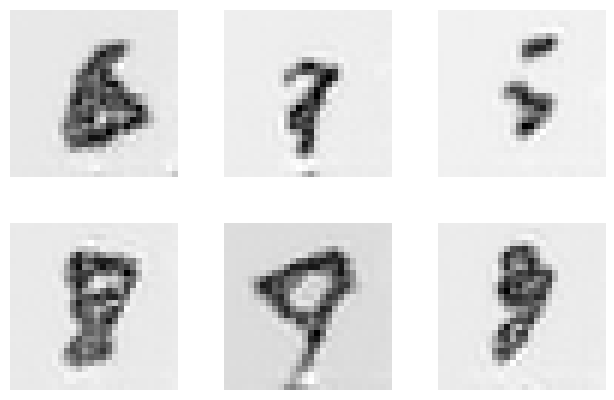

Epoch: 11


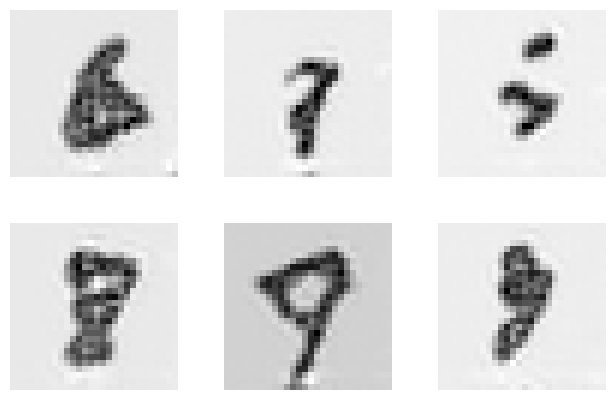

Epoch: 12


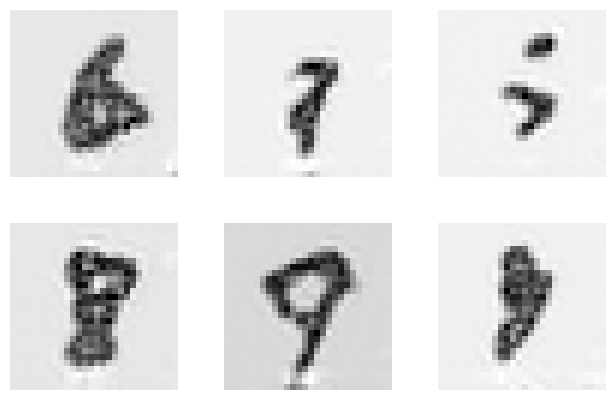

Epoch: 13


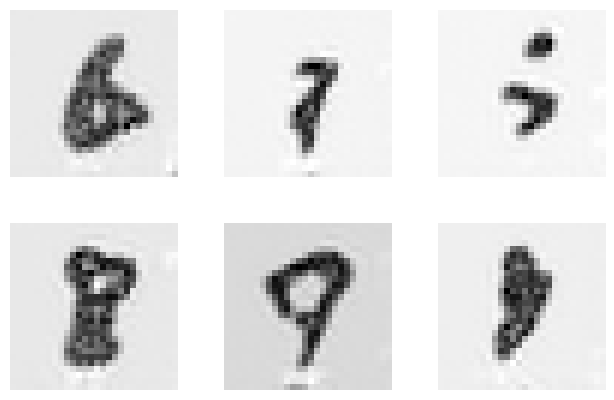

Epoch: 14


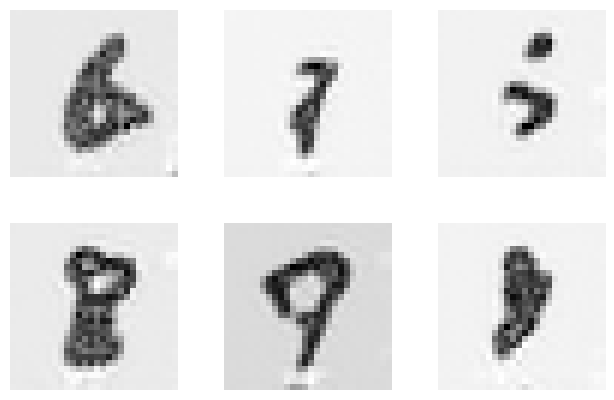

Epoch: 15


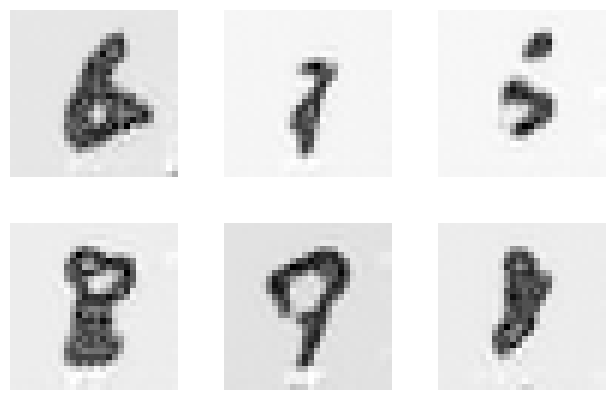

Epoch: 16


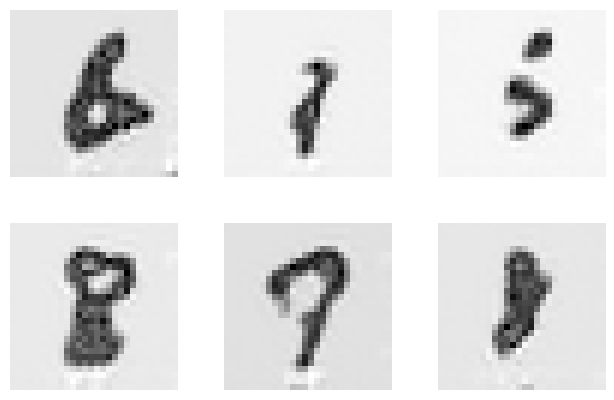

Epoch: 17


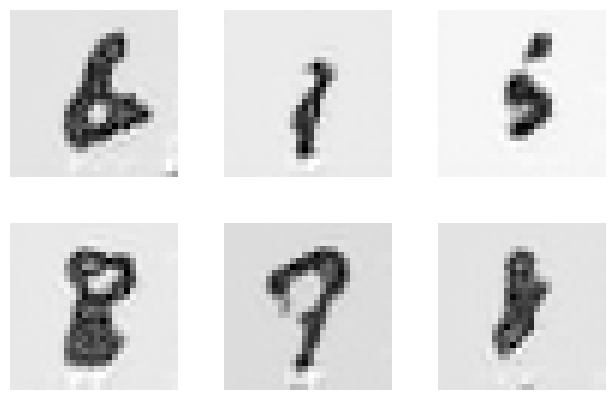

Epoch: 18


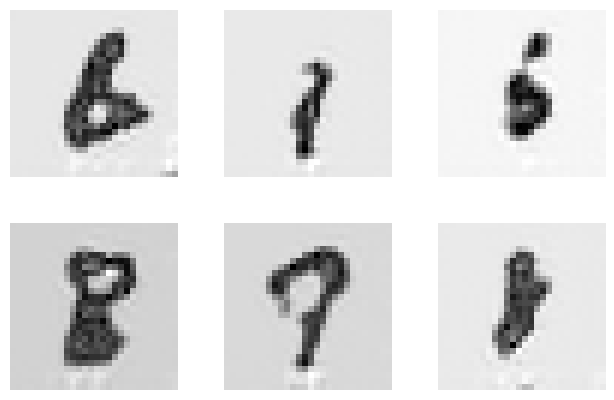

Epoch: 19


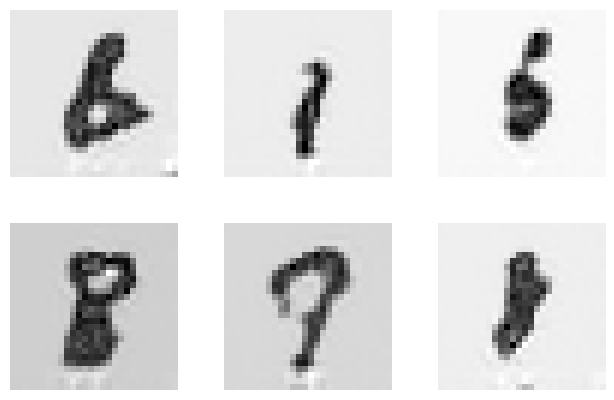

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [29]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)

In [30]:
losses = model.loss

for key, item in losses.items():
  losses[key] = [x.item() for x in item]


It's interesting to observe how the generator loss is increasing with training. Ideally it should be decreasing -> Potentially explaisn why the images don't look as good as intended.

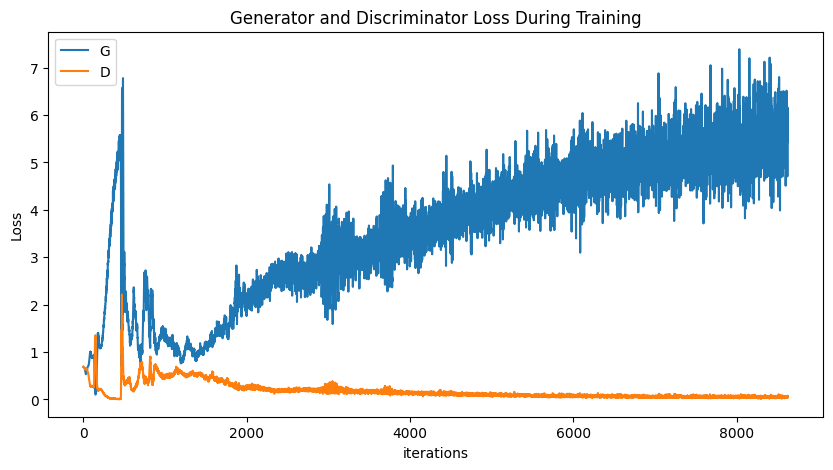

In [31]:
d_loss = losses['d_loss']
g_loss = losses['g_loss']

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss, label="G")
plt.plot(d_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()